## Introduction
** **
Topic Models, in a nutshell, are a type of statistical language models used for uncovering hidden structure in a collection of texts. In a practical and more intuitively, you can think of it as a task of:

- **Dimensionality Reduction**, where rather than representing a text T in its feature space as {Word_i: count(Word_i, T) for Word_i in Vocabulary}, you can represent it in a topic space as {Topic_i: Weight(Topic_i, T) for Topic_i in Topics}
- **Unsupervised Learning**, where it can be compared to clustering, as in the case of clustering, the number of topics, like the number of clusters, is an output parameter. By doing topic modeling, we build clusters of words rather than clusters of texts. A text is thus a mixture of all the topics, each having a specific weight
- **Tagging**, abstract “topics” that occur in a collection of documents that best represents the information in them.

There are several existing algorithms you can use to perform the topic modeling. The most common of it are, Latent Semantic Analysis (LSA/LSI), Probabilistic Latent Semantic Analysis (pLSA), and Latent Dirichlet Allocation (LDA)

In this tutorial, we’ll take a closer look at LDA, and implement our first topic model using the sklearn implementation in python 2.7

### Theoretical Overview
LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities.

![LDA_Model](https://github.com/chdoig/pytexas2015-topic-modeling/blob/master/images/lda-4.png?raw=true)

We can describe the generative process of LDA as, given the M number of documents, N number of words, and prior K number of topics, the model trains to output:

- `psi`, the distribution of words for each topic K
- `phi`, the distribution of topics for each document i

#### Parameters of LDA

- `Alpha parameter` is Dirichlet prior concentration parameter that represents document-topic density — with a higher alpha, documents are assumed to be made up of more topics and result in more specific topic distribution per document.
- `Beta parameter` is the same prior concentration parameter that represents topic-word density — with high beta, topics are assumed to made of up most of the words and result in a more specific word distribution per topic.

**To read more: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0**

** **
### LDA Implementation

1. [Loading data](#load_data)
2. [Data cleaning](#clean_data)
3. [Exploratory analysis](#eda)
4. [Prepare data for LDA analysis](#data_preparation)
5. [LDA model training](#train_model)
6. [Analyzing LDA model results](#results)

** **
For this tutorial, we’ll use the dataset of papers published in NeurIPS (NIPS) conference which is one of the most prestigious yearly events in the machine learning community. The CSV data file contains information on the different NeurIPS papers that were published from 1987 until 2016 (29 years!). These papers discuss a wide variety of topics in machine learning, from neural networks to optimization methods, and many more.

<img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_158/img/nips_logo.png" alt="The logo of NIPS (Neural Information Processing Systems)">

Let’s start by looking at the content of the file

** **
#### Step 1: Loading Data <a class="anchor\" id="load_data"></a>
** **

In [40]:
# Importing modules
import pandas as pd
import os

# os.chdir('..')

# Read data into papers
pages = pd.read_csv('odb_pages_text.csv', encoding='cp1252')

# Print head
pages.head()

,url,books,text
0,https://odb.org/cookies-and-other-tracking-tec...,{'Hebrew': 1},love god love others sign in give toggle navig...
1,https://odb.org/subscription/,{'Hebrew': 1},love god love others sign in give toggle navig...
2,https://odb.org/2022/03/27/undefined,"{'Judges': 1, 'Luke': 3, '1 Peter': 3}",sign in support bookmark 0:00 itunesdownload m...
3,https://odb.org/author/billcrowder/,"{'Daniel': 2, 'Luke': 2, 'John': 2, '1 Thessal...",love god love others sign in give toggle navig...
4,https://odb.org/2021/07/11/reunited/,"{'Psalms': 1, 'Acts': 3, '1 Thessalonians': 3}",sign in support bookmark 0:00 itunesdownload m...


** **
#### Step 3: Exploratory Analysis <a class="anchor\" id="eda"></a>
** **

To verify whether the preprocessing, we’ll make a simple word cloud using the `wordcloud` package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

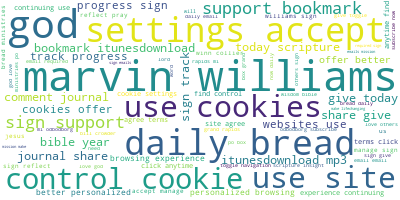

In [36]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(pages['text'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

** **
#### Step 4: Prepare text for LDA analysis <a class="anchor\" id="data_preparation"></a>
** **

Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by tokenizing the text and removing stopwords. Next, we convert the tokenized object into a corpus and dictionary.

In [57]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
from nltk.corpus import stopwords
import re

stop_words = stopwords.words('english')
stop_words.extend(['daily', 'bread', 'crowder', 'collier', 'winn', 'bill', 'bookmark', 'site', 'cookies', 'ministries',
                   'sign', 'cookies', 'us', 'one', 'make', 'god', 'gods', 'people', 'give', 'bible', 'jesus', 'life',
                   'marvin', 'williams', 'like', 'also', 'settings', 'many', 'find', 'use', 'email', 'author', ':', 
                   'today', 'v', '–'])

def clean_text(text):
  text = re.sub(':', ' ', text)
  text = re.sub('([0-9]+)', '', text)
  text_tokens = [word for word in text.split(' ')
                            if word not in stop_words]
  text_tokens = [word_rooter(word) for word in text_tokens]
  return ' '.join(text_tokens)

pages['clean_text'] = pages.text.apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [58]:
from sklearn.feature_extraction.text import CountVectorizer

# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf = vectorizer.fit_transform(pages['clean_text']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names_out()

** **
#### Step 5: LDA model tranining <a class="anchor\" id="train_model"></a>
** **

To keep things simple, we'll keep all the parameters to default except for inputting the number of topics. For this tutorial, we will build a model with 10 topics where each topic is a combination of keywords, and each keyword contributes a certain weightage to the topic.

In [81]:
from sklearn.decomposition import LatentDirichletAllocation

number_of_topics = 25

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

model.fit(tf)

LatentDirichletAllocation(n_components=25, random_state=0)

In [89]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

no_top_words = 5
display_topics(model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,...,Topic 20 words,Topic 20 weights,Topic 21 words,Topic 21 weights,Topic 22 words,Topic 22 weights,Topic 23 words,Topic 23 weights,Topic 24 words,Topic 24 weights
0,sin,138.1,joy,44.1,offer,38.6,etern,68.6,good,102.5,...,scriptur,46.0,word,184.8,use,256.3,love,71.1,love,75.5
1,forgiv,41.2,worship,33.2,grudg,38.1,love,60.7,news,100.8,...,job,44.6,pray,175.6,love,239.7,thing,58.1,world,58.9
2,confess,39.6,wealth,28.8,full,36.3,help,53.9,joy,41.0,...,control,43.8,offer,137.6,grand,189.0,world,53.1,year,58.1
3,david,28.9,money,28.1,empti,34.0,choic,49.7,heard,40.3,...,offer,43.6,person,128.3,rapid,188.9,power,47.3,manag,58.0
4,repent,26.8,gate,27.5,forgiv,33.7,gift,47.3,need,33.2,...,lord,42.9,love,127.6,pastor,165.7,place,44.0,person,57.7


In [85]:
import numpy as np

# predict topics for test data
# unnormalized doc-topic distribution
doc_topic_dist_unnormalized = np.matrix(model.transform(tf))

# normalize the distribution (only needed if you want to work with the probabilities)
doc_topic_dist = doc_topic_dist_unnormalized/doc_topic_dist_unnormalized.sum(axis=1)
doc_topic_dist.argmax(axis=1)
pages['topic'] = pd.Series(doc_topic_dist.argmax(axis=1).A1)

,url,topic
0,https://odb.org/cookies-and-other-tracking-tec...,22
1,https://odb.org/subscription/,22
2,https://odb.org/2022/03/27/undefined,14
3,https://odb.org/author/billcrowder/,17
4,https://odb.org/2021/07/11/reunited/,17
...,...,...
671,https://odb.org/2017/05/08/the-burden-of-waiting/,12
672,https://odb.org/2017/03/24/his-wonderful-face/,21
673,http://odb.org/all-authors,22
674,http://odb.org/author/patriciaraybon,9


In [90]:
topics = pages[['url', 'topic']].groupby('topic')
topics.get_group(4)

,url,topic
103,https://odb.org/2022/02/27/the-joy-of-good-news/,4
158,https://odb.org/2022/02/27/the-joy-of-good-news/,4
177,https://odb.org/2022/02/27/the-joy-of-good-news/,4
198,https://odb.org/2022/02/27/the-joy-of-good-news/,4
205,https://odb.org/2022/02/27/the-joy-of-good-news/,4
212,https://odb.org/2022/02/27/the-joy-of-good-news/,4
224,https://odb.org/2022/02/27/the-joy-of-good-news/,4
